In [22]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import os

In [23]:
cwd = os.getcwd()
print(cwd)

c:\Users\alexa\Documents\PYTHON\PyTorch-Tests


In [24]:
time = torch.linspace(0, 1000, 10000)

In [25]:
def Input(time=time, tau_n=10, I_n=1, I_0=0.005, start=100, end=900):
    
    """
    Génération d'un input bruité 
    time (array) : vecteur de temps
    tau_n (float) : constante de temps de l'évolution temporel de l'input
    I_n (float) : variabilité de l'input
    I_0 (float) : niveau de base de l'input
    start (int) : début de la stimulation
    end (int) : fin de la stimulation
    return :
        - I (array) : valeur de l'input à chaque unité de temps
    """

    dt = time[1]
    I = torch.ones_like(time)

    for t in range(len(I) - 1) :

        n = torch.randn(1) * I_n
        I[t+1] = (1 - dt/tau_n) * I[t]+ (dt * n/tau_n)
    
    I += I_0
    I[time<start], I[time>end] = 0, 0
    
    return I

def RQIF(time=time, I=[], v_spike= 1, a=0.01, b=0.01, c=0.01, d=0.01):
    
    """
    Modèle "Quadratic Integrated and Fire"
    time (array) : vecteur de temps
    v_spike (float) : valeur du spike
    a, b, c, d (float) : paramètres mathématiques du modèle
    return :
        - V (array) : évolution temporelle du potentiel membranaire
        - U (array) : évolution temporelle du niveau de calcium intraqcellulaire
    """

    V = torch.zeros_like(time) * c
    U = torch.zeros_like(time)
    dt = time[1]

    for t in range(len(time) - 1) :

        dV = dt * (V[t]**2 - U[t] + I[t])
        dU = dt * (a * (b * V[t] - U[t]))
        V[t+1] = V[t] + dV
        U[t+1] = U[t] + dU
        
        if V[t] >= v_spike :
        
            V[t+1] = c
            U[t+1] = U[t] + d
            
    return V, U

In [26]:
class Estimator(torch.nn.Module):
    """Some Information about Estimator"""
    def __init__(self,
                 a,
                 b,
                 c,
                 d
                ):
        super(Estimator, self).__init__()

        self.a = torch.nn.Parameter(torch.ones(1) * a)
        self.b = torch.nn.Parameter(torch.ones(1) * b)
        self.c = torch.nn.Parameter(torch.ones(1) * c)
        self.d = torch.nn.Parameter(torch.ones(1) * d)

    def forward(self, I):
        
        V, U = RQIF(time=time, I=I,
                    a=self.a, b=self.b,c=self.c, d=self.d)
        
        return V

In [27]:
def training(
        X,
        Y,

        lr=5 * 10**-3,
        num_epochs=500,
        device="cpu",
        criterion=torch.nn.MSELoss(reduction="mean")):

    # model initialisation
    model = Estimator(a=0.01, b=0.01, c=0.01, d=0.01)
    
    # Optimizer initialisation
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Training
    losses = []

    for _ in tqdm(range(num_epochs)):

        model.train()
        model.to(device)
        outputs = model(I=X)

        loss = criterion(outputs, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    
    return model, losses

In [28]:
I = Input(start=100, end=900)
V,U = RQIF(I=I, a=0.5, b=0.1, c=0.1, d=0.01)

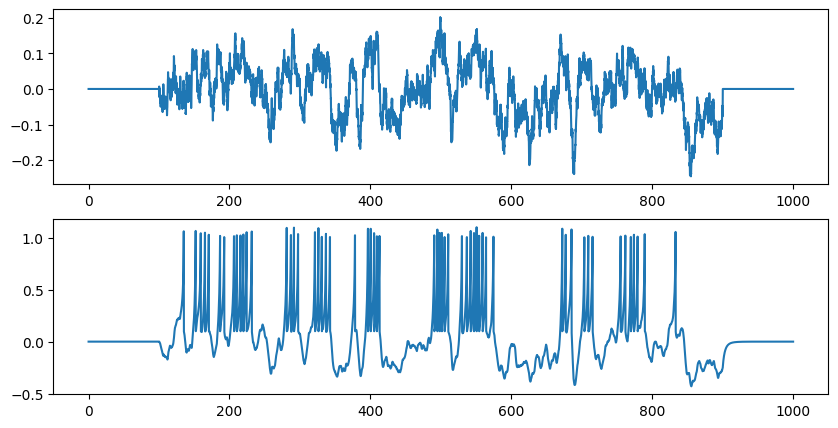

In [29]:
fig,ax = plt.subplots(nrows=2, ncols=1, figsize=(10,5))
ax[0].plot(time, I)
ax[1].plot(time, V)
plt.show()

In [21]:
training(X=I, Y=V)

  0%|          | 0/500 [00:02<?, ?it/s]


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor []], which is output 0 of AsStridedBackward0, is at version 10032; expected version 10031 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [62]:
torch.autograd.set_detect_anomaly(True)